In [15]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from itertools import combinations

# 1. Load Model and Data
model = SentenceTransformer('all-MiniLM-L6-v2')
df = pd.read_csv("PreprocessedText.csv")

# 2. Define Category Anchors
anchors = {
    "government": "government state policy funding regulation",
    "industry": "industry private sector business companies",
    "academia": "academia universities research science labs",
    "society": "society citizens public engagement ethics"
}
cat_labels = list(anchors.keys())
anchor_embeddings = model.encode(list(anchors.values()), convert_to_tensor=True)

# 3. Calculate Scores
results = []
for _, row in df.iterrows():
    text_emb = model.encode(str(row['text']), convert_to_tensor=True)
    scores = util.cos_sim(text_emb, anchor_embeddings)[0]
    
    doc_scores = {cat_labels[i]: scores[i].item() for i in range(len(cat_labels))}
    doc_scores['country'] = row['country']
    results.append(doc_scores)

score_df = pd.DataFrame(results)

# --- NEW: Diagnostic Step ---
print("Max scores found per category:")
print(score_df[cat_labels].max())
# ----------------------------

# 4. Identify Relationships
# Lowered threshold to 0.25 for tokenized data
threshold = 0.25 

relationships = []
for _, row in score_df.iterrows():
    active = [cat for cat in cat_labels if row[cat] > threshold]
    if len(active) >= 2:
        for pair in combinations(sorted(active), 2):
            relationships.append({
                'country': row['country'], 
                'pair': " <-> ".join(pair)
            })

# 5. Show the Results with a safety check
if len(relationships) > 0:
    rel_df = pd.DataFrame(relationships)
    print("\nTop Relationships Found Semantically:")
    print(rel_df['pair'].value_counts())
else:
    print(f"\nNo pairs found above threshold {threshold}. Try lowering the threshold further.")

Max scores found per category:
government    0.198800
industry      0.226688
academia      0.209578
society       0.058205
dtype: float64

No pairs found above threshold 0.25. Try lowering the threshold further.


C:\Users\user\AppData\Local\Temp\ipykernel_31568\3046498375.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted_scores, x='variable', y='value', palette='Set2')


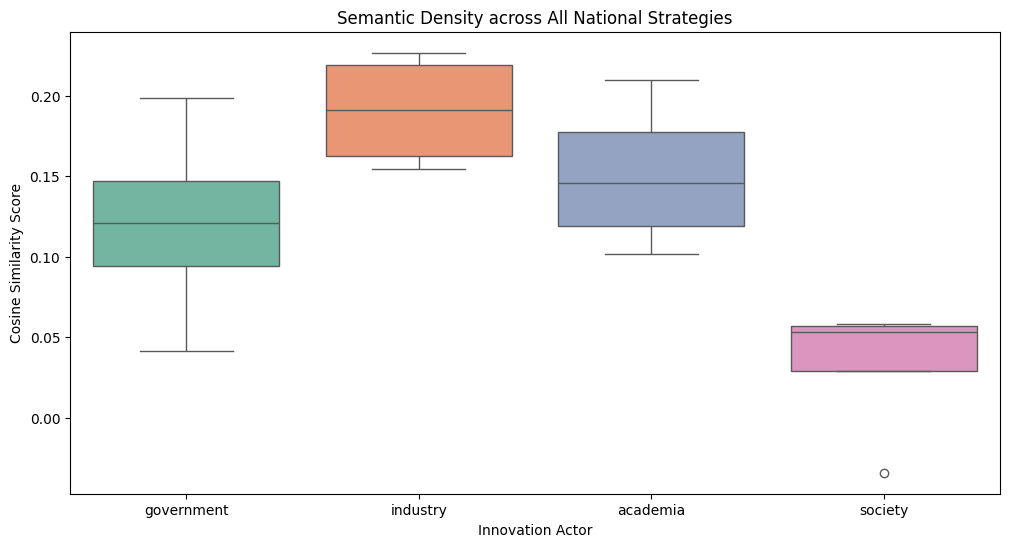

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using the score_df generated previously
plt.figure(figsize=(12, 6))
# Melt the dataframe for plotting
melted_scores = score_df.melt(id_vars=['country'], value_vars=['government', 'industry', 'academia', 'society'])

sns.boxplot(data=melted_scores, x='variable', y='value', palette='Set2')
plt.title("Semantic Density across All National Strategies")
plt.ylabel("Cosine Similarity Score")
plt.xlabel("Innovation Actor")
plt.show()